In [1]:
from collections import deque
import glob
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision as tv
from torchinfo import summary
from tqdm import notebook

from hidden_space_visualization import add_embedding

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

# Dataset

In [2]:
BATCH_SIZE = 1024

with np.load('D:/Datasets/mnist.npz') as mnist:
    x_train, y_train, x_test, y_test = mnist['x_train'], mnist['y_train'], mnist['x_test'], mnist['y_test']

dataloader = torch.utils.data.DataLoader([*zip(x_train, y_train)], batch_size=BATCH_SIZE, shuffle=True)

# Models

In [3]:
H_DIM = 8
LEAKY = 0.1  # LeakyReLU coefficient
CHANNELS_IMG = 1

FEATURES_DISC = 32
FEATURES_GEN = 16

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1), nn.LeakyReLU(LEAKY),
            self._block(features_d,     features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
#             self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(  features_d * 4, 1             , 4, 2, 0), nn.Sigmoid(),
        )

    def forward(self, x):
        return self.conv(x)
    
    def _block(self, inp_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(inp_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(LEAKY),
        )
    
discriminator = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(DEVICE)
discriminator_ = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(DEVICE)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

# print(discriminator(torch.zeros((2, 1, 32, 32)).to(DEVICE)).shape)
summary(discriminator, (2, 1, 32, 32), verbose=0, depth=2, device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [2, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [2, 32, 16, 16]           544
│    └─LeakyReLU: 2-2                    [2, 32, 16, 16]           --
│    └─Sequential: 2-3                   [2, 64, 8, 8]             32,768
│    └─Sequential: 2-4                   [2, 128, 4, 4]            131,072
│    └─Conv2d: 2-5                       [2, 1, 1, 1]              2,049
│    └─Sigmoid: 2-6                      [2, 1, 1, 1]              --
Total params: 166,433
Trainable params: 166,433
Non-trainable params: 0
Total mult-adds (M): 8.67
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 0.67
Estimated Total Size (MB): 0.90

In [5]:
class Generator(nn.Module):
    def __init__(self, h_dim, channels_img, features_g):
        super().__init__()
        self.convT = nn.Sequential(
            self._block(h_dim,               features_g *16, 4, 1, 0),
            self._block(features_g * 16,     features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
#             self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(  features_g * 4, channels_img  , 4, 2, 1), nn.Tanh(),
        )
        
    def forward(self, x):
        return self.convT(x.unsqueeze(-1).unsqueeze(-1))
    
    def _block(self, inp_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(inp_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
#             nn.LeakyReLU(LEAKY),
            nn.ReLU(),
        )
    
generator = Generator(H_DIM, CHANNELS_IMG, FEATURES_GEN).to(DEVICE)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=3e-5, betas=(0.5, 0.999))

# print(generator(torch.randn((2, H_DIM)).to(DEVICE)).shape)
summary(generator, (2, H_DIM), verbose=0, depth=2, device=DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [2, 1, 32, 32]            --
│    └─Sequential: 2-1                   [2, 256, 4, 4]            33,280
│    └─Sequential: 2-2                   [2, 128, 8, 8]            524,544
│    └─Sequential: 2-3                   [2, 64, 16, 16]           131,200
│    └─ConvTranspose2d: 2-4              [2, 1, 32, 32]            1,025
│    └─Tanh: 2-5                         [2, 1, 32, 32]            --
Total params: 690,049
Trainable params: 690,049
Non-trainable params: 0
Total mult-adds (M): 137.37
Input size (MB): 0.00
Forward/backward pass size (MB): 0.93
Params size (MB): 2.76
Estimated Total Size (MB): 3.69

## Models weights initialization

In [10]:
## DISCRIMINATOR
# for layer in chain(discriminator.conv.children()):
#     if isinstance(layer, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
#         nn.init.normal_(layer.weight, 0, 0.02)

## GENERATOR
for layer in chain(generator.convT.children()):
    if isinstance(layer, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
        nn.init.normal_(layer.weight, 0, 0.02)

## Learning Rate

In [28]:
# GET DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    print(pg['lr'])

0.0002


In [32]:
# CHANGE DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    pg['lr'] = 3e-4

In [18]:
# GET GENERATOR LR

for pg in optimizer_g.param_groups:
    print(pg['lr'])

3e-05


In [19]:
# CHANGE GENERATOR LR

for pg in optimizer_g.param_groups:
    pg['lr'] = 1e-5

# Tensorboard

In [6]:
tb = SummaryWriter('runs/DCGAN_with_buffer_MNIST/fake')

In [ ]:
tb.close()

# Training

In [7]:
step = 1

In [16]:
FIXED_NOISE = torch.randn(24, H_DIM).to(DEVICE)  # hidden points for samples

In [9]:
BUFFER_LEN = 30

try:
    buffer = deque(list(buffer)[:BUFFER_LEN], maxlen=BUFFER_LEN)
except NameError:
    buffer = deque( maxlen=BUFFER_LEN)

In [20]:
EPOCHS = 1000
MONITORING_INTERVAL = 30  # epoch interval to save result images eamples
SAVE_INTERVAL = 3  # save model weights and optimizer state every SAVE_INTERVAL epoch; use 0 for no save
BUFFER_SAMPLES_N = 10


for epoch in range(EPOCHS):
    pbar = notebook.tqdm(dataloader)
    for batch_idx, (x_real, lbl) in enumerate(pbar):
        pbar.set_description(f'EPOCHE={epoch + 1}')

        x_real = x_real / 255.
        x_real = x_real * 2 - 1
        x_real = x_real.unsqueeze(1).to(DEVICE, dtype=torch.float)
        x_real = tv.transforms.Resize(32)(x_real)
        
        batch_size = x_real.shape[0]
        noise = torch.randn((batch_size, H_DIM)).to(DEVICE)  # batch_size // 10
        
        ## DISCRIMINATOR
        discriminator.train()
        generator.eval()
        fake = generator(noise)


        discriminator.zero_grad()
        discriminator_real = discriminator(x_real).view(-1)
        loss_d_real = nn.BCELoss()(discriminator_real, torch.ones_like(discriminator_real, device=DEVICE))
        for fk in (fake, *random.choices(buffer, k=min(BUFFER_SAMPLES_N, len(buffer)))):
            discriminator_fake = discriminator(fake.to(DEVICE)).view(-1)
            loss_d_fake = nn.BCELoss()(discriminator_fake, torch.zeros_like(discriminator_fake, device=DEVICE)) / (min(BUFFER_SAMPLES_N, len(buffer)) + 1)
            loss_d = (loss_d_real + loss_d_fake) / 2
            loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        accuracy_d = accuracy_score(torch.cat([discriminator_real, discriminator_fake], dim=0).detach().round().to('cpu'), 
                                    torch.cat([torch.ones_like(discriminator_real), torch.zeros_like(discriminator_fake)], dim=0).detach().round().to('cpu'))
        
        ## GENERATOR
        discriminator.eval()
        generator.train()
        fake = generator(noise)
        buffer.append(fake.detach().to('cpu'))
        
        output = discriminator(fake).view(-1)
        loss_g = nn.BCELoss()(output, torch.ones_like(output, device=DEVICE))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        ## MONITORING
        pbar.set_postfix({'accuracy_d->': accuracy_d, 'loss_d->': float(loss_d), 'loss_g->': float(loss_g), 'step->': str(step)})
        
        step += 1


        ## SAVE IMAGES EXAMPLES
        if MONITORING_INTERVAL and not step % MONITORING_INTERVAL:
            generator.eval()
            with torch.no_grad():
                tb.add_images('DCGAN FAKE', ((generator(FIXED_NOISE) + 1) / 2).detach().view(-1, 1, 32, 32), global_step=step - 1)

    ## SAVE MODEL WEIGHTS AND OPTIMIZER STATE
    if SAVE_INTERVAL and not epoch % SAVE_INTERVAL:
        torch.save({
            'discriminator': discriminator.state_dict(), 
            'optimizer_d': optimizer_d.state_dict(),
            'generator': generator.state_dict(), 
            'optimizer_g': optimizer_g.state_dict(),
            }, f'checkpoints/weights_DCGAN_with_buffer-MNIST-hdim{H_DIM}-step{step - 1}.pth')

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
## LOAD

params = torch.load('checkpoints/_weights_DCGAN_with_buffer-MNIST-hdim8.pth', map_location=DEVICE)

# generator.load_state_dict(params)  # for `generator_only` weights

discriminator.load_state_dict(params['discriminator'])
generator.load_state_dict(params['generator'])
optimizer_d.load_state_dict(params['optimizer_d'])
optimizer_g.load_state_dict(params['optimizer_g'])

# Let's Play

In [21]:
generator.eval();

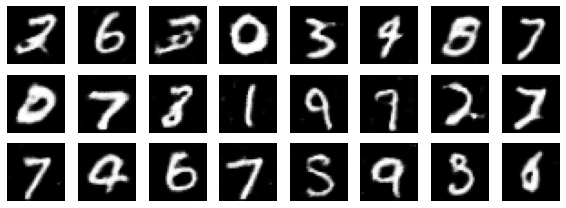

In [22]:
## Plot examples

fig, axs = plt.subplots(3, 8, figsize=(8, 3))
with torch.no_grad():
    for ax, fake_i in zip(axs.ravel(), (generator(FIXED_NOISE).detach().to('cpu') + 1) / 2):
        ax.imshow(fake_i.permute(1, 2, 0), cmap='gray')
        ax.axis('off')
plt.tight_layout()

In [23]:
FIXED_NOISE_BIG = torch.randn(200, H_DIM).to(DEVICE)

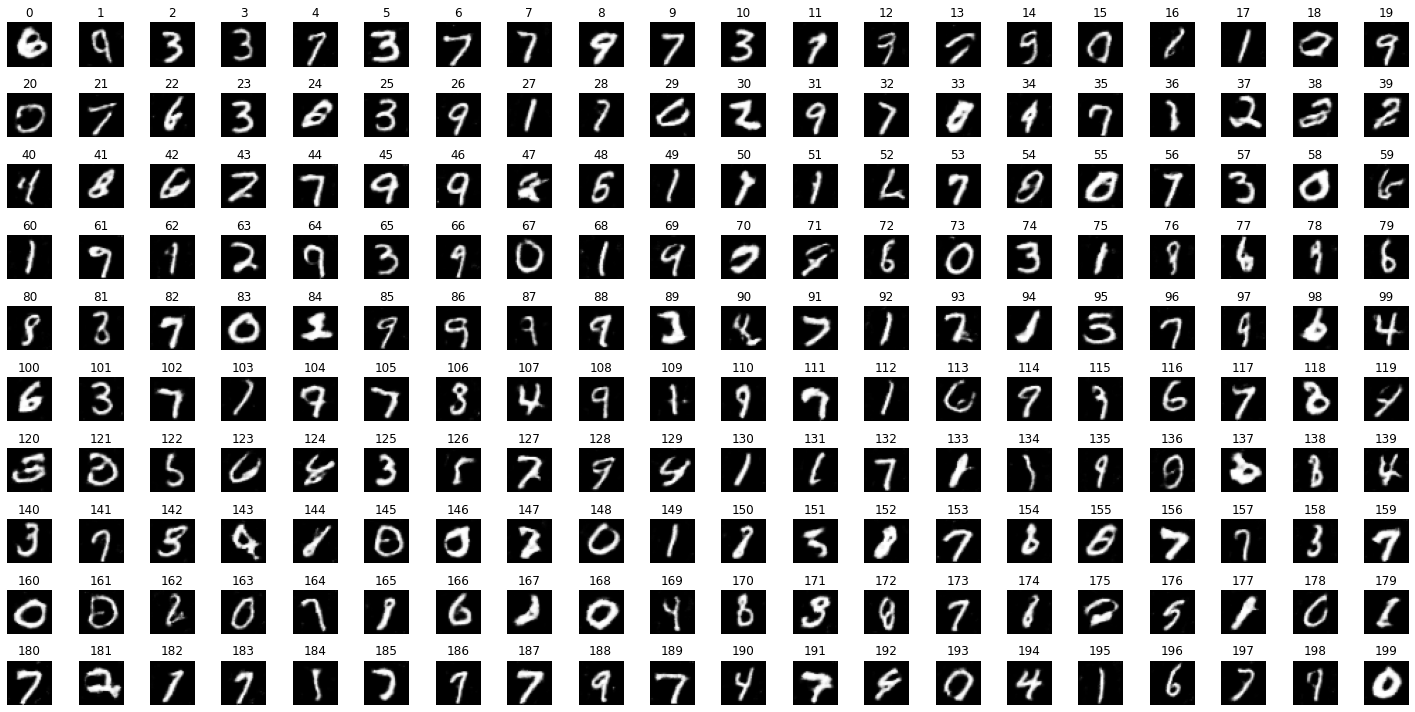

In [24]:
fig, axs = plt.subplots(10, 20, figsize=(20, 10))
with torch.no_grad():
    for i, (ax, fake_i) in enumerate(zip(axs.ravel(), generator(FIXED_NOISE_BIG).detach())):
        ax.imshow(fake_i.permute(1, 2, 0).to('cpu'), cmap='gray')
        ax.axis('off')
        ax.set_title(i)
plt.tight_layout()

# Hidden space visualization

In [17]:
add_embedding(generator, summary_writer=tb, h_dim=H_DIM, tag='DCGAN_with_buffer_8D', device=DEVICE)

2709 samples is used.
